Project root on sys.path: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS
PV CSV: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS/data/strategies/generation/latest.csv
Market CSV: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS/data/strategies/market/latest.csv
Charging Strategy: Immediate
Strategy Status: Immediate

Verwendetes Szenario: office
Ladepunkte: 5
Zeitraum: 2025-06-04 00:00:00 bis 2025-06-13 23:45:00
Horizont: 10 Tage

Sessions
Ankünfte mit Ladebedarf: 149
mit Ladezugang: 53
ohne Ladezugang (drive_off): 96
Alle Fahrzeuge haben Ziel-SoC erreicht.
Daytypes: {'working_day': 7, 'saturday': 1, 'sunday_holiday': 2}


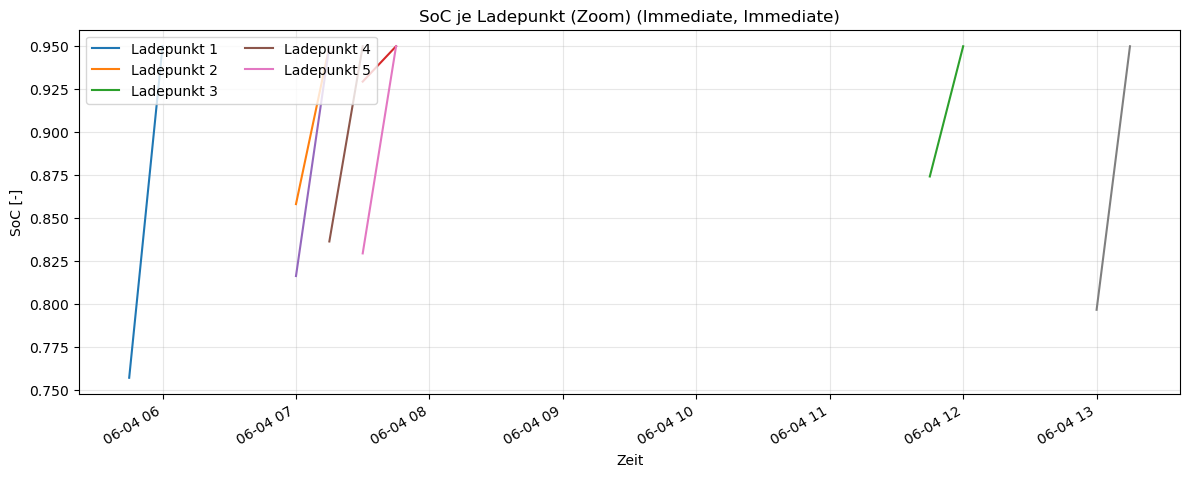

Überschreitungen: 5


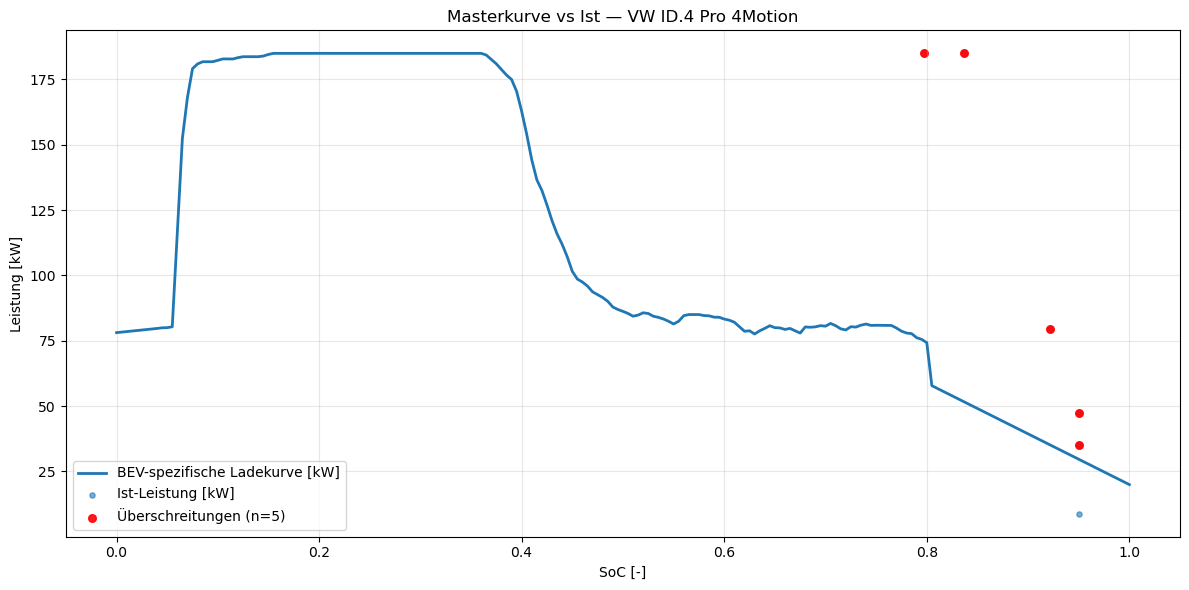

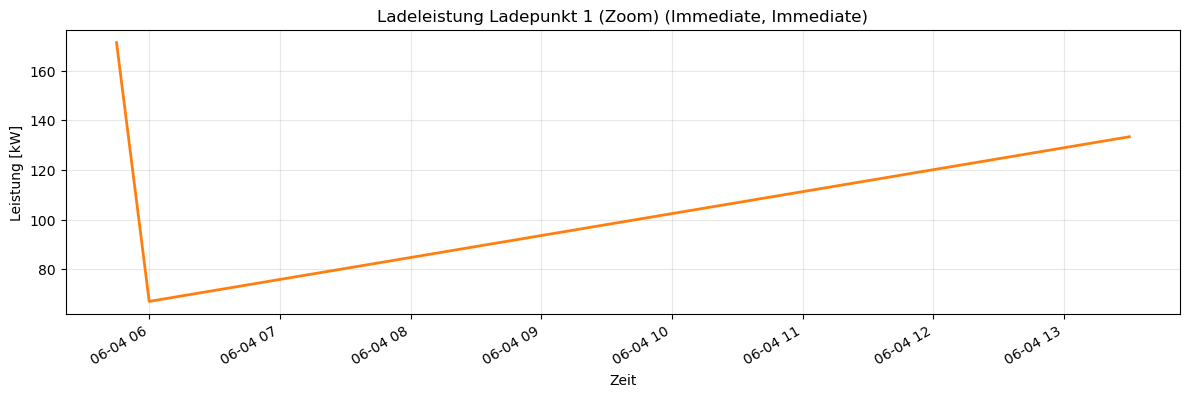

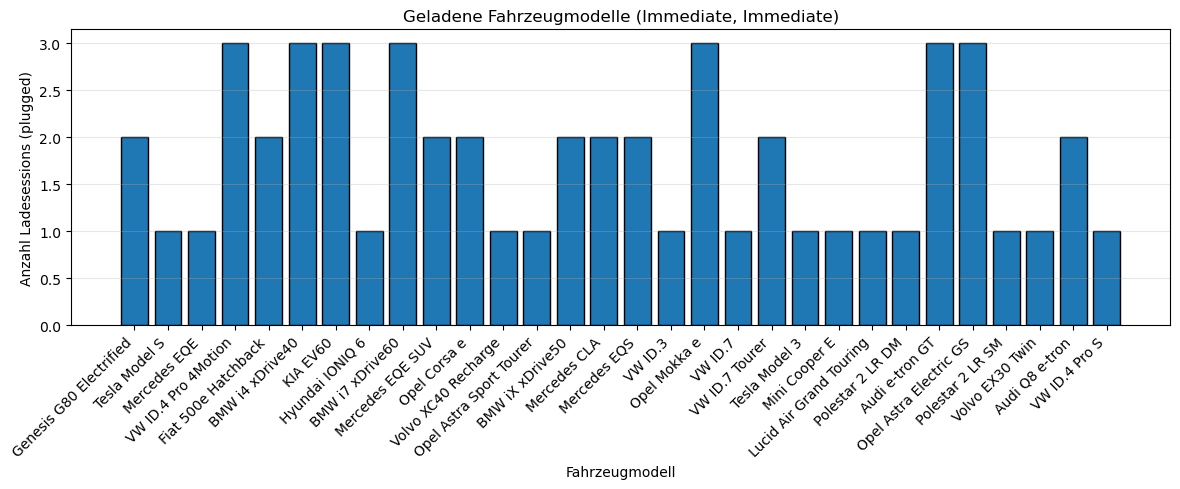

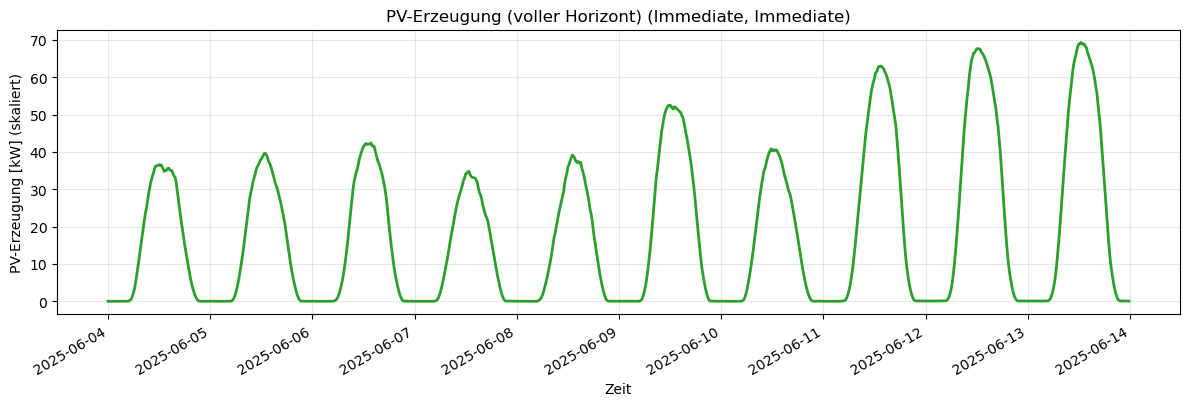

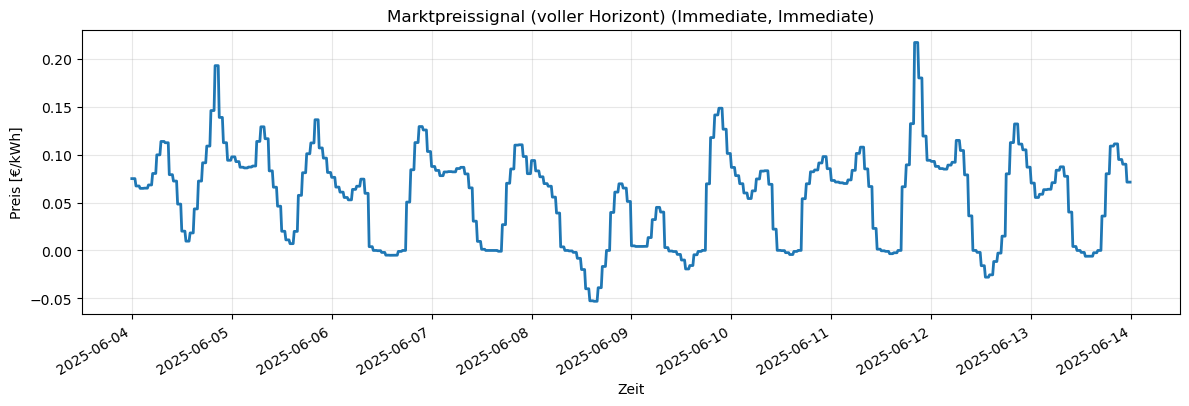

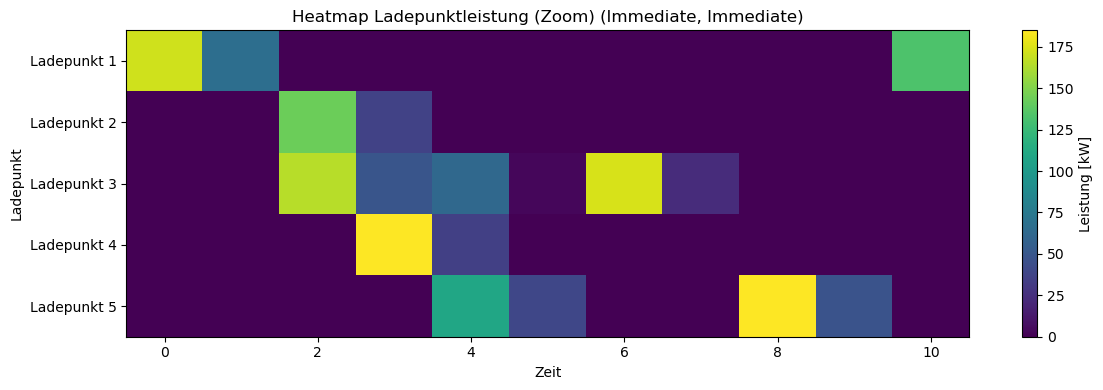

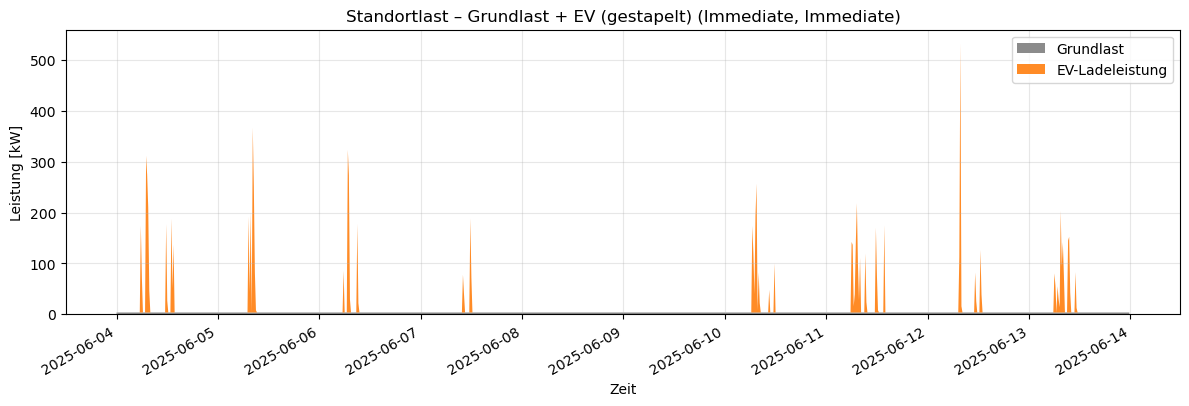

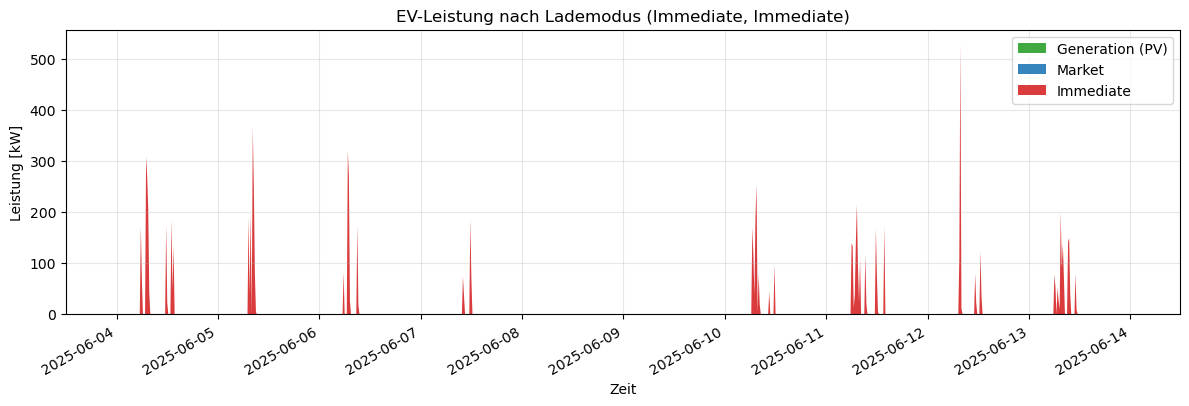

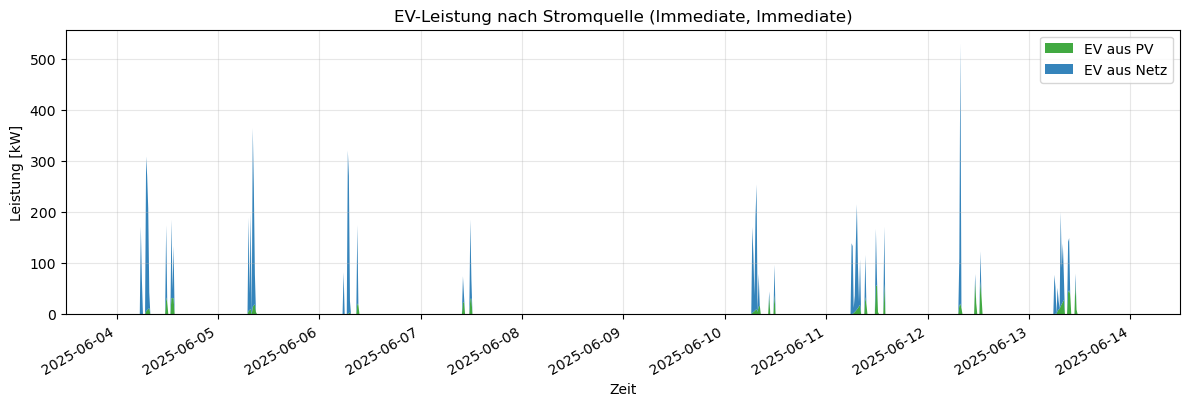

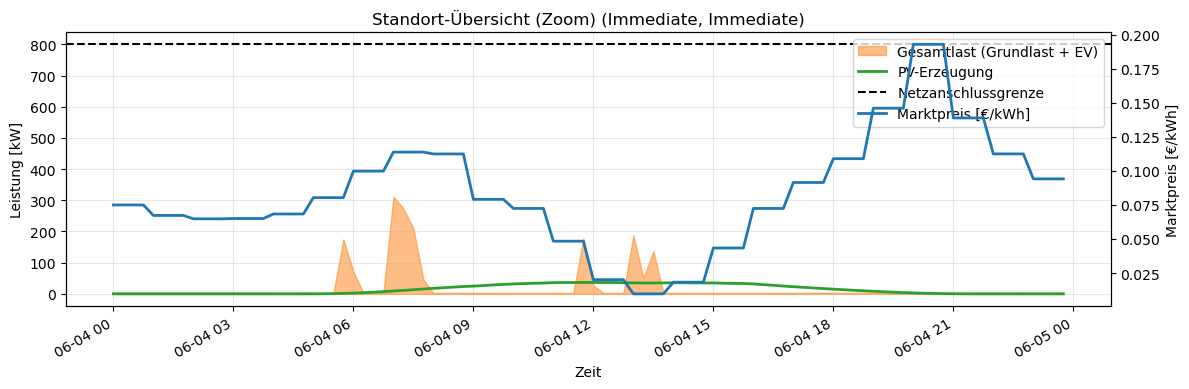

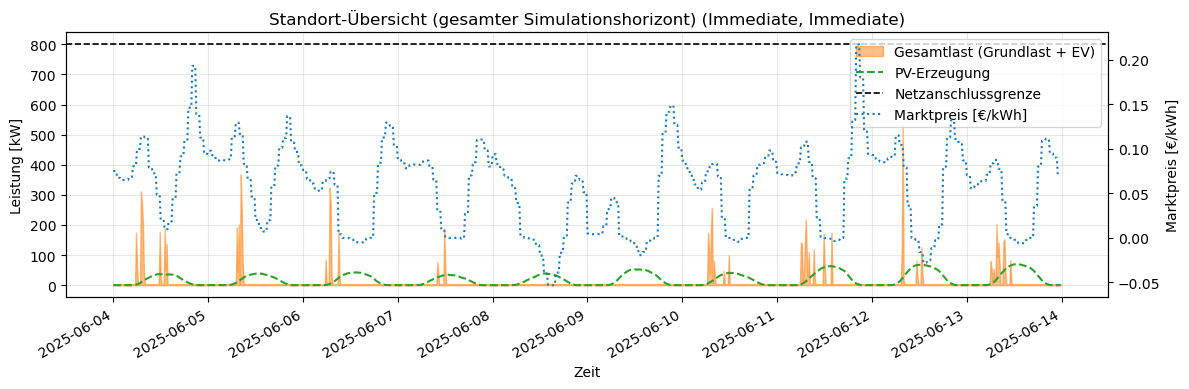

,session_id,charger_id,vehicle_name,arrival_time,departure_time,state_of_charge_at_arrival,state_of_charge_end,charged_site_kwh,charged_pv_site_kwh,charged_market_site_kwh,charged_immediate_site_kwh,remaining_site_kwh
0,2025-06-04_000_00018,0,Genesis G80 Electrified,2025-06-04 05:45:00,2025-06-04 13:15:00,0.265217,0.95,59.576103,0.0,0.0,59.576103,0.0
1,2025-06-04_000_00004,1,Tesla Model S,2025-06-04 07:00:00,2025-06-04 14:45:00,0.499587,0.95,45.041336,0.0,0.0,45.041336,0.0
2,2025-06-04_000_00017,2,Mercedes EQE,2025-06-04 07:00:00,2025-06-04 07:30:00,0.363604,0.95,53.362032,0.0,0.0,53.362032,0.0
3,2025-06-04_000_00016,3,VW ID.4 Pro 4Motion,2025-06-04 07:15:00,2025-06-04 15:45:00,0.235984,0.95,54.979214,0.0,0.0,54.979214,0.0
4,2025-06-04_000_00009,2,Fiat 500e Hatchback,2025-06-04 07:30:00,2025-06-04 11:00:00,0.558388,0.95,16.447696,0.0,0.0,16.447696,0.0
5,2025-06-04_000_00012,4,BMW i4 xDrive40,2025-06-04 07:30:00,2025-06-04 13:00:00,0.492032,0.95,37.095372,0.0,0.0,37.095372,0.0
6,2025-06-04_000_00006,2,KIA EV60,2025-06-04 11:45:00,2025-06-04 19:30:00,0.309165,0.95,49.344306,0.0,0.0,49.344306,0.0
7,2025-06-04_000_00023,4,VW ID.4 Pro 4Motion,2025-06-04 13:00:00,2025-06-04 18:15:00,0.196280,0.95,58.036403,0.0,0.0,58.036403,0.0
8,2025-06-04_000_00019,0,KIA EV60,2025-06-04 13:30:00,2025-06-04 23:15:00,0.517067,0.95,33.335821,0.0,0.0,33.335821,0.0
9,2025-06-05_001_00009,0,BMW i4 xDrive40,2025-06-05 07:15:00,2025-06-05 15:00:00,0.245059,0.95,57.100218,0.0,0.0,57.100218,0.0


In [ ]:
# =============================================================================
# A) Scenario Setup
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"

zoom_days = 1
random_seed = 42

# =============================================================================
# B) Imports
# =============================================================================
import os
import sys
import warnings
from pathlib import Path
from datetime import datetime, timedelta
from collections import Counter
import importlib.util

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# -----------------------------------------------------------------------------
# Warnings: Standard ist sinnvoller als "always".
# Wenn du gezielt nur den Pandas-Parsing-Warnhinweis unterdrücken willst,
# kannst du die filterwarnings-Zeile aktivieren.
# -----------------------------------------------------------------------------
warnings.simplefilter("default", UserWarning)
# warnings.filterwarnings(
#     "ignore",
#     message="Could not infer format, so each element will be parsed individually",
#     category=UserWarning,
# )

# =============================================================================
# C) Plot Colors (semantisch konsistent)
# =============================================================================
COLOR_PV = "#2ca02c"          # grün
COLOR_MARKET = "#1f77b4"      # blau
COLOR_GRID = COLOR_MARKET
COLOR_IMMEDIATE = "#d62728"   # rot
COLOR_SITE_LOAD = "#ff7f0e"   # orange
COLOR_BASELOAD = "#7f7f7f"    # grau
COLOR_TOTAL = "black"
COLOR_GRID_LIMIT = "black"

# =============================================================================
# D) Notebook Helper Functions
# =============================================================================
def show_strategy_status(charging_strategy: str, strategy_status: str) -> None:
    """
    Printet eine kurze Statuszeile für die gewählte Lademanagementstrategie.

    Parameters
    ----------
    charging_strategy : str
        Name der Strategie aus dem Szenario (z.B. "immediate", "market", "generation").
    strategy_status : str
        Statusindikator (z.B. "ACTIVE" oder "IMMEDIATE").
    """
    strategy_name = (charging_strategy or "immediate").capitalize()
    status_name = (strategy_status or "immediate").capitalize()
    print(f"Charging Strategy: {strategy_name}")
    print(f"Strategy Status: {status_name}")


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    """
    Baut einen Plot-Titel, der zusätzlich Strategie und Status enthält.

    Parameters
    ----------
    base_title : str
        Grundtitel des Plots.
    charging_strategy : str
        Strategie-Name.
    strategy_status : str
        Status-Text.

    Returns
    -------
    str
        Formatierter Titel.
    """
    strategy_name = (charging_strategy or "immediate").capitalize()
    status_name = (strategy_status or "immediate").capitalize()
    return f"{base_title} ({strategy_name}, {status_name})"


def ensure_project_root_on_syspath() -> str:
    """
    Sucht den Projekt-Root (Ordner, der 'model/' enthält) und fügt ihn in sys.path ein.

    Returns
    -------
    str
        Absoluter Pfad zum Projekt-Root.
    """
    current_working_directory = Path.cwd().resolve()
    candidate_directories = [current_working_directory] + list(current_working_directory.parents)

    for candidate in candidate_directories:
        model_directory = candidate / "model"
        if model_directory.exists() and model_directory.is_dir():
            root_path = str(candidate)
            if root_path not in sys.path:
                sys.path.insert(0, root_path)
            return root_path

    fallback_root = str((current_working_directory / "..").resolve())
    if fallback_root not in sys.path:
        sys.path.insert(0, fallback_root)
    return fallback_root


# =============================================================================
# E) Load simulation module
# =============================================================================
project_root = ensure_project_root_on_syspath()
print("Project root on sys.path:", project_root)

simulation_module_path = Path(project_root) / "model" / "simulation.py"
if not simulation_module_path.exists():
    simulation_module_path = Path.cwd().resolve() / "simulation.py"

specification = importlib.util.spec_from_file_location("simulation_module", simulation_module_path)
sim = importlib.util.module_from_spec(specification)
sys.modules[specification.name] = sim
specification.loader.exec_module(sim)

from model.simulation import (
    show_strategy_status,
    decorate_title_with_status,
    initialize_time_window,
    get_holiday_dates_from_scenario,
    get_daytype_calendar,
    group_sessions_by_day,
    resolve_paths_relative_to_yaml,
    make_timeseries_dataframe,
)


# =============================================================================
# F) Shortcuts (Builder + Kernfunktionen)
# =============================================================================
load_scenario = sim.read_scenario_from_yaml
build_strategy_signal_series = getattr(sim, "build_strategy_signal_series", None)

build_plugged_sessions_preview_table = sim.build_plugged_sessions_preview_table
summarize_sessions = sim.summarize_sessions

build_power_per_charger_timeseries = sim.build_power_per_charger_timeseries
build_soc_timeseries_by_charger = sim.build_soc_timeseries_by_charger
build_charger_power_heatmap_matrix = sim.build_charger_power_heatmap_matrix
build_ev_power_by_source_timeseries = sim.build_ev_power_by_source_timeseries
build_site_overview_plot_data = sim.build_site_overview_plot_data
build_ev_power_by_mode_timeseries_dataframe = sim.build_ev_power_by_mode_timeseries_dataframe
validate_against_master_curves = sim.validate_against_master_curves

# =============================================================================
# G) Load scenario + resolve relative paths
# =============================================================================
scenario = load_scenario(scenario_path)
scenario = resolve_paths_relative_to_yaml(scenario, scenario_path)

print("PV CSV:", scenario["site"].get("generation_strategy_csv"))
print("Market CSV:", scenario["site"].get("market_strategy_csv"))

# =============================================================================
# H) Build timestamps + input time series
# =============================================================================
timestamps = sim.build_simulation_timestamps(scenario)

time_index = timestamps

holiday_dates = get_holiday_dates_from_scenario(scenario, timestamps)

time_resolution_min = int(scenario["time_resolution_min"])
step_hours = float(time_resolution_min) / 60.0

site_configuration = scenario["site"]

if site_configuration.get("base_load_csv"):
    base_load_series = sim.read_local_load_profile_from_csv(
        csv_path=str(site_configuration["base_load_csv"]),
        value_column_one_based=int(site_configuration["base_load_value_col"]),
        value_unit=str(site_configuration["base_load_unit"]),
        annual_scaling_value=float(site_configuration["base_load_annual"]),
        time_resolution_min=time_resolution_min,
        timestamps=timestamps,
    )
    base_load_kwh_per_step = base_load_series.to_numpy(dtype=float)
else:
    base_load_kw_constant = float(site_configuration.get("base_load_kw", 0.0))
    base_load_kwh_per_step = np.full(len(timestamps), base_load_kw_constant * step_hours, dtype=float)

# Strategy signals
pv_generation_series = None
pv_generation_ylabel = None

market_price_series = None
market_price_ylabel = None

if build_strategy_signal_series is not None:
    pv_generation_series, pv_generation_ylabel = build_strategy_signal_series(
        scenario=scenario,
        timestamps=timestamps,
        charging_strategy="generation",
        normalize_to_internal=True,
        strategy_resolution_min=time_resolution_min,
    )

    market_price_series, market_price_ylabel = build_strategy_signal_series(
        scenario=scenario,
        timestamps=timestamps,
        charging_strategy="market",
        normalize_to_internal=True,
        strategy_resolution_min=time_resolution_min,
    )

pv_generation_kwh_per_step = (
    np.array(pv_generation_series, dtype=float)
    if pv_generation_series is not None
    else np.zeros(len(timestamps), dtype=float)
)
market_price_eur_per_kwh = (
    np.array(market_price_series, dtype=float)
    if market_price_series is not None
    else None
)

vehicle_charging_curves_by_name = sim.read_vehicle_load_profiles_from_csv(
    str(scenario["vehicles"]["vehicle_curve_csv"])
)

# Requested: pv_scale defined
pv_scale = float(site_configuration.get("pv_system_size_kwp", 0.0)) / max(
    float(site_configuration.get("pv_profile_reference_kwp", 1.0)),
    1e-12,
)

# =============================================================================
# I) Sample sessions + run simulation
# =============================================================================
random_generator = np.random.default_rng(int(random_seed))
start_datetime = datetime.fromisoformat(str(scenario["start_datetime"]))
simulation_horizon_days = int(scenario["simulation_horizon_days"])

sampled_sessions_all_days = []
for day_index in range(simulation_horizon_days):
    simulation_day_start = start_datetime + timedelta(days=day_index)
    sampled_sessions_for_day = sim.sample_sessions_for_simulation_day(
        scenario=scenario,
        simulation_day_start=simulation_day_start,
        timestamps=timestamps,
        holiday_dates=holiday_dates,
        vehicle_curves_by_name=vehicle_charging_curves_by_name,
        random_generator=random_generator,
        day_index=day_index,
    )
    sampled_sessions_all_days.extend(sampled_sessions_for_day)

ev_load_kw, sessions_out, debug_rows, charger_traces = sim.simulate_charging_sessions_fcfs(
    sessions=sampled_sessions_all_days,
    vehicle_curves_by_name=vehicle_charging_curves_by_name,
    scenario=scenario,
    timestamps=timestamps,
    pv_generation_kwh_per_step=pv_generation_kwh_per_step,
    base_load_kwh_per_step=base_load_kwh_per_step,
    market_price_eur_per_kwh=market_price_eur_per_kwh,
    record_debug=True,
    record_charger_traces=True,
)

charging_strategy = str(site_configuration.get("charging_strategy", "immediate")).strip().lower()
strategy_status = "IMMEDIATE" if charging_strategy == "immediate" else "ACTIVE"
show_strategy_status(charging_strategy, strategy_status)

charger_traces_dataframe = pd.DataFrame(charger_traces if charger_traces is not None else [])
steps_per_day, window_start, window_end = initialize_time_window(
    timestamps=timestamps,
    scenario=scenario,
    days=zoom_days,
)

timeseries_dataframe = make_timeseries_dataframe(
    timestamps=timestamps,
    ev_load_kw=ev_load_kw,
    scenario=scenario,
    debug_rows=debug_rows,
    pv_generation_series=pv_generation_series,
    market_price_series=market_price_series,
)

# =============================================================================
# J) KPIs
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Ladepunkte:", int(site_configuration["number_chargers"]))
print("Zeitraum:", timestamps[0], "bis", timestamps[-1])
print("Horizont:", simulation_horizon_days, "Tage")

summary = summarize_sessions(sessions_out)
print("\nSessions")
print("Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("mit Ladezugang:", summary["num_sessions_plugged"])
print("ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

not_reached_dataframe = pd.DataFrame(summary["not_reached_rows"])
if len(not_reached_dataframe) == 0:
    print("Alle Fahrzeuge haben Ziel-SoC erreicht.")
else:
    not_reached_dataframe = not_reached_dataframe.sort_values("remaining_energy_kwh", ascending=False).reset_index(drop=True)
    print("Ziel-SoC nicht erreicht:", len(not_reached_dataframe))
    display(not_reached_dataframe)

daytypes_calendar = get_daytype_calendar(
    start_datetime=start_datetime,
    horizon_days=simulation_horizon_days,
    holiday_dates=holiday_dates,
)
sessions_by_day = group_sessions_by_day(sessions_out, only_plugged=False)
sessions_by_day_plugged = group_sessions_by_day(sessions_out, only_plugged=True)
print("Daytypes:", {k: len(v) for k, v in daytypes_calendar.items()})

# =============================================================================
# K) PLOTS
# =============================================================================

site_configuration = scenario["site"]

# 1) SoC je Ladepunkt (Zoom) – Linien werden pro Session unterbrochen
soc_by_charger_id = build_soc_timeseries_by_charger(
    charger_traces_dataframe=charger_traces_dataframe,
    charger_ids=list(range(int(site_configuration["number_chargers"]))),
    start=window_start,
    end=window_end,
)

plt.figure(figsize=(12, 5))

for charger_id, soc_dataframe in soc_by_charger_id.items():
    if soc_dataframe is None or len(soc_dataframe) == 0:
        continue

    # Falls session_id fehlt, fallback: normal plotten (keine Unterbrechung möglich)
    if "session_id" not in soc_dataframe.columns:
        plt.plot(
            soc_dataframe["timestamp"],
            soc_dataframe["soc"],
            linewidth=1.5,
            label=f"Ladepunkt {charger_id + 1}",
        )
        continue

    # Pro Session plotten => automatisch Unterbrechung zwischen Sessions
    soc_dataframe = soc_dataframe.sort_values("timestamp")
    first_segment = True

    for _, segment in soc_dataframe.groupby("session_id"):
        if len(segment) < 2:
            continue

        plt.plot(
            segment["timestamp"],
            segment["soc"],
            linewidth=1.5,
            label=f"Ladepunkt {charger_id + 1}" if first_segment else None,
        )
        first_segment = False

plt.xlabel("Zeit")
plt.ylabel("SoC [-]")
plt.title(decorate_title_with_status("SoC je Ladepunkt (Zoom)", charging_strategy, strategy_status))
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", ncols=2)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()



# 2) Kurvenvalidierung – CSV-Ladekurve vs. Ist-Ladekurve

most_used_vehicle_name = sim.get_most_used_vehicle_name(
    sessions_out=sessions_out,
    charger_traces_dataframe=charger_traces_dataframe,
    only_plugged_sessions=True,
)

plot_data = sim.build_master_curve_and_actual_points_for_vehicle(
    charger_traces_dataframe=charger_traces_dataframe,
    scenario=scenario,
    vehicle_name=most_used_vehicle_name,
    start=None,
    end=None,  # ganzer Horizont
)

print("Überschreitungen:", plot_data["number_violations"])

plt.figure(figsize=(12, 6))

# 1) maximal aufnehmbare Batterie-Leistung (CSV)
plt.plot(
    plot_data["master_soc"],
    plot_data["master_power_battery_kw"],
    linewidth=2,
    label="BEV-spezifische Ladekurve [kW]",
)

# 2) tatsächlich aufgenommene Leistung (Ist)
plt.scatter(
    plot_data["actual_soc"],
    plot_data["actual_power_kw"],
    s=14,
    alpha=0.6,
    label="Ist-Leistung [kW]",
)

# 3) Überschreitungen
if plot_data["number_violations"] > 0:
    mask = plot_data["violation_mask"]
    plt.scatter(
        plot_data["actual_soc"][mask],
        plot_data["actual_power_kw"][mask],
        s=30,
        alpha=0.9,
        color="red",
        label=f"Überschreitungen (n={plot_data['number_violations']})",
    )

plt.xlabel("SoC [-]")
plt.ylabel("Leistung [kW]")
plt.title(f"Masterkurve vs Ist — {plot_data['vehicle_name']}")
plt.grid(True, alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


# 3) Leistung eines Ladepunkts (Zoom)
charger_id_to_plot = 0
charger_label = charger_id_to_plot + 1  # Anzeige 1-basiert

charger_power_dataframe = build_power_per_charger_timeseries(
    charger_traces_dataframe,
    charger_id=charger_id_to_plot,
    start=window_start,
    end=window_end,
)

plt.figure(figsize=(12, 4))
plt.plot(
    charger_power_dataframe["timestamp"],
    charger_power_dataframe["power_kw"],
    color=COLOR_SITE_LOAD,
    linewidth=2,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status(f"Ladeleistung Ladepunkt {charger_label} (Zoom)", charging_strategy, strategy_status))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 4) Fahrzeugzählung (plugged Sessions)
plugged_sessions = [s for s in sessions_out if s.get("_plug_in_time") is not None]
vehicle_counts = Counter([s.get("vehicle_name", "") for s in plugged_sessions])

plt.figure(figsize=(12, 5))
plt.bar(list(vehicle_counts.keys()), list(vehicle_counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 5) PV-Erzeugung (voller Horizont)
if "pv_generation_kw" in timeseries_dataframe.columns and timeseries_dataframe["pv_generation_kw"].notna().any():
    plt.figure(figsize=(12, 4))
    plt.plot(timeseries_dataframe["ts"], timeseries_dataframe["pv_generation_kw"], linewidth=2, color=COLOR_PV)
    plt.xlabel("Zeit")
    plt.ylabel("PV-Erzeugung [kW] (skaliert)")
    plt.title(decorate_title_with_status("PV-Erzeugung (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()
else:
    print("Kein pv_generation_kw in timeseries_dataframe.")

# 6) Marktpreissignal (voller Horizont)
if market_price_series is not None and market_price_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, market_price_series, linewidth=2, color=COLOR_MARKET)
    plt.xlabel("Zeit")
    plt.ylabel(market_price_ylabel)
    plt.title(decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

# 7) Heatmap (Zoom)
heatmap = build_charger_power_heatmap_matrix(
    charger_traces_dataframe,
    start=window_start,
    end=window_end,
)

plt.figure(figsize=(12, 4))
plt.imshow(heatmap["matrix"], aspect="auto", interpolation="nearest")
plt.colorbar(label="Leistung [kW]")

plt.yticks(
    ticks=np.arange(len(heatmap["charger_ids"])),
    labels=[f"Ladepunkt {int(i) + 1}" for i in heatmap["charger_ids"]],
)

plt.title(decorate_title_with_status("Heatmap Ladepunktleistung (Zoom)", charging_strategy, strategy_status))
plt.xlabel("Zeit")
plt.ylabel("Ladepunkt")
plt.tight_layout()
plt.show()


# 8) Standortlast gestapelt (voller Horizont) – Base + EV
plt.figure(figsize=(12, 4))
plt.stackplot(
    timeseries_dataframe["ts"],
    timeseries_dataframe["base_load_kw"].astype(float).fillna(0.0),
    timeseries_dataframe["ev_load_kw"].astype(float).fillna(0.0),
    labels=["Grundlast", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_SITE_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("Standortlast – Grundlast + EV (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 9) EV-Leistung nach Modus (generation / market / immediate)
mode_dataframe = build_ev_power_by_mode_timeseries_dataframe(
    timeseries_dataframe=timeseries_dataframe,
    sessions_out=sessions_out,
    scenario=scenario,
)

plt.figure(figsize=(12, 4))
plt.stackplot(
    mode_dataframe["timestamp"],
    mode_dataframe["ev_generation_kw"],
    mode_dataframe["ev_market_kw"],
    mode_dataframe["ev_immediate_kw"],
    labels=["Generation (PV)", "Market", "Immediate"],
    colors=[COLOR_PV, COLOR_MARKET, COLOR_IMMEDIATE],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("EV-Leistung nach Lademodus", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 10) EV-Leistung nach Quelle (PV vs Netz)
ev_power_by_source_dataframe = build_ev_power_by_source_timeseries(timeseries_dataframe)

plt.figure(figsize=(12, 4))
plt.stackplot(
    ev_power_by_source_dataframe["timestamp"],
    ev_power_by_source_dataframe["ev_from_pv_kw"],
    ev_power_by_source_dataframe["ev_from_grid_kw"],
    labels=["EV aus PV", "EV aus Netz"],
    colors=[COLOR_PV, COLOR_GRID],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("EV-Leistung nach Stromquelle", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 11a) Standort-Übersicht (Zoom) – Fläche + PV gestrichelt + Marktpreis
site_overview_data = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=window_start,
    end=window_end,
)

overview_dataframe = site_overview_data["dataframe"]
total_load_kw = site_overview_data["total_load_kw"]
pv_generation_kw = site_overview_data["pv_generation_kw"]
grid_limit_kw = site_overview_data["grid_limit_kw"]

# Marktpreis-Spalte suchen
market_price_column = None
for candidate in ["market_price_eur_per_kwh", "market_price", "price_eur_per_kwh"]:
    if candidate in overview_dataframe.columns:
        market_price_column = candidate
        break

fig, ax_load = plt.subplots(figsize=(12, 4))

# --- Gesamtlast als Fläche (orange) ---
ax_load.fill_between(
    overview_dataframe["timestamp"],
    total_load_kw,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

# --- PV-Erzeugung (grün, gestrichelt) ---
if pv_generation_kw is not None:
    ax_load.plot(
        overview_dataframe["timestamp"],
        pv_generation_kw,
        color=COLOR_PV,
        linestyle="-",
        linewidth=2,
        label="PV-Erzeugung",
    )

# --- Grid-Limit ---
ax_load.axhline(
    grid_limit_kw,
    linestyle="--",
    linewidth=1.5,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

# --- Marktpreis (rechte Achse) ---
if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe["timestamp"],
        overview_dataframe[market_price_column],
        linestyle="-",
        linewidth=2,
        color=COLOR_MARKET,
        label="Marktpreis [€/kWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/kWh]")
else:
    ax_price = None

# --- gemeinsame Legende ---
lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2

ax_load.legend(lines, labels, loc="upper right")

plt.title(decorate_title_with_status("Standort-Übersicht (Zoom)", charging_strategy, strategy_status))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


# 11b) Standort-Übersicht (gesamter Simulationshorizont)
site_overview_data_full = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=None,
    end=None,
)

overview_dataframe_full = site_overview_data_full["dataframe"]
total_load_kw_full = site_overview_data_full["total_load_kw"]
pv_generation_kw_full = site_overview_data_full["pv_generation_kw"]
grid_limit_kw_full = site_overview_data_full["grid_limit_kw"]

market_price_column = None
for candidate in ["market_price_eur_per_kwh", "market_price", "price_eur_per_kwh"]:
    if candidate in overview_dataframe_full.columns:
        market_price_column = candidate
        break

fig, ax_load = plt.subplots(figsize=(12, 4))

# Gesamtlast als Fläche
ax_load.fill_between(
    overview_dataframe_full["timestamp"],
    total_load_kw_full,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

# PV-Erzeugung gestrichelt
if pv_generation_kw_full is not None:
    ax_load.plot(
        overview_dataframe_full["timestamp"],
        pv_generation_kw_full,
        color=COLOR_PV,
        linestyle="--",
        linewidth=1.5,
        label="PV-Erzeugung",
    )

# Grid-Limit
ax_load.axhline(
    grid_limit_kw_full,
    linestyle="--",
    linewidth=1.2,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

# Marktpreis
if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe_full["timestamp"],
        overview_dataframe_full[market_price_column],
        linestyle=":",
        linewidth=1.5,
        color=COLOR_MARKET,
        label="Marktpreis [€/kWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/kWh]")
else:
    ax_price = None

# Legende
lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2

ax_load.legend(lines, labels, loc="upper right")

plt.title(
    decorate_title_with_status(
        "Standort-Übersicht (gesamter Simulationshorizont)",
        charging_strategy,
        strategy_status,
    )
)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 12) Plugged Sessions Preview
display(build_plugged_sessions_preview_table(sessions_out, n=20))
